In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt

import torch

## Step 1: load energy consumption data with AKNN features (from Demo 1-0)

In [2]:
summary_train_data = pd.read_csv('./temp_data/train_data.csv')
summary_train_data.head()

,datetime,hvac,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,dayofweek,hourofday,kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5
0,2018-06-01 00:00:00,52.0200,30.9775,54.9725,523.5250,6.8225,4,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-01 01:00:00,53.4200,30.2250,56.5750,340.5000,6.8150,4,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-01 02:00:00,46.1500,28.6225,59.8725,159.7250,6.7675,4,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-01 03:00:00,48.4225,25.6075,68.2775,21.1750,7.1100,4,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-01 04:00:00,45.5000,23.0425,72.4475,0.1525,6.6850,4,4,2.708823e-66,3.959091e-79,0.999466,0.000002,0.000266,0.000266


In [3]:
summary_test_data = pd.read_csv('./temp_data/test_data.csv')
summary_test_data.head()

,datetime,hvac,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,dayofweek,hourofday,kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5
0,2019-07-01 00:00:00,34.100071,34.8850,55.8600,554.3000,10.3625,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01 01:00:00,30.898862,33.8300,57.7150,372.9000,10.2025,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01 02:00:00,35.306293,32.2800,60.9675,190.0250,10.1275,0,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-01 03:00:00,38.267875,29.1225,69.9450,35.9475,10.0475,0,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01 04:00:00,35.271825,26.2825,78.7200,0.1400,9.9350,0,4,6.040098e-16,4.210736e-14,0.994472,2.549270e-09,3.677319e-27,0.005528


<AxesSubplot:xlabel='datetime'>

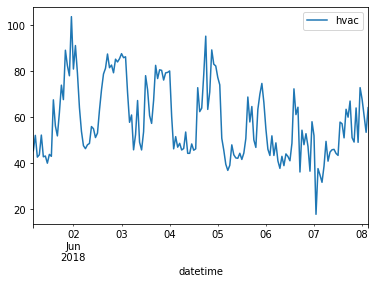

In [4]:
summary_train_data['datetime'] = pd.to_datetime(summary_train_data['datetime'])
summary_train_data['date'] = summary_train_data['datetime'].dt.date
summary_train_data['year'] = summary_train_data['datetime'].dt.year
summary_train_data = summary_train_data.dropna()
summary_train_data.iloc[:24*7, :].plot(x='datetime', y='hvac')

In [5]:
summary_train_data.columns

Index(['datetime', 'hvac', 'air_temp', 'relative_humidity_set_1',
       'solar_radiation_set_1', 'dew_point_temperature_set_1d', 'dayofweek',
       'hourofday', 'kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4',
       'kernel_5', 'date', 'year'],
      dtype='object')

In [6]:
summary_train_data = summary_train_data[['datetime', 'year', 'date', 'dayofweek', 'hourofday', 'air_temp', 'relative_humidity_set_1', 'solar_radiation_set_1', 
                                        'dew_point_temperature_set_1d', 'kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'hvac']]

In [7]:
summary_test_data['datetime'] = pd.to_datetime(summary_test_data['datetime'])
summary_test_data['date'] = summary_test_data['datetime'].dt.date
summary_test_data['year'] = summary_test_data['datetime'].dt.year
summary_test_data = summary_test_data.dropna()
summary_test_data = summary_test_data[['datetime', 'year', 'date', 'dayofweek', 'hourofday', 'air_temp', 'relative_humidity_set_1', 'solar_radiation_set_1', 
                                        'dew_point_temperature_set_1d', 'kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'hvac']]

In [8]:
### MinMaxScaler
def scaler_fit(data):
    scaler = MinMaxScaler()
    col_names_1 = data.columns
    data1 = data.copy()
    data1 = data1.drop(columns=['datetime', 'year', 'date'])
    col_names_2 = data1.columns
    scaler.fit(data1)
    data1 = scaler.transform(data1)
    data1 = pd.DataFrame(data1, columns=col_names_2)
    data1['datetime'] = data['datetime'].tolist()
    data1['year'] = data['year'].tolist()
    data1['date'] = data['date'].tolist()
    return scaler, data1[col_names_1]

def scaler_transform(scaler, data):

    col_names_1 = data.columns
    data1 = data.copy()
    data1 = data1.drop(columns=['datetime', 'year', 'date'])
    col_names_2 = data1.columns
    data1 = scaler.transform(data1)
    data1 = pd.DataFrame(data1, columns=col_names_2)
    data1['datetime'] = data['datetime'].tolist()
    data1['year'] = data['year'].tolist()
    data1['date'] = data['date'].tolist()
    return data1[col_names_1]

scaler, summary_train_data = scaler_fit(summary_train_data)
summary_test_data = scaler_transform(scaler, summary_test_data)

In [9]:
summary_train_data

,datetime,year,date,dayofweek,hourofday,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,kernel_0,kernel_1,kernel_2,kernel_3,hvac
0,2018-06-01 04:00:00,2018,2018-06-01,0.666667,0.173913,0.102543,0.736007,0.000151,0.705069,2.709496e-66,3.959355e-79,0.999466,2.049371e-06,0.369540
1,2018-06-01 05:00:00,2018,2018-06-01,0.666667,0.217391,0.089933,0.726302,0.000069,0.691120,4.968989e-67,1.183797e-79,0.998885,4.159569e-07,0.423550
2,2018-06-01 06:00:00,2018,2018-06-01,0.666667,0.260870,0.088186,0.771308,0.000030,0.709848,4.185433e-66,2.650875e-76,0.998806,1.526667e-07,0.346799
3,2018-06-01 07:00:00,2018,2018-06-01,0.666667,0.304348,0.080177,0.785279,0.000035,0.709719,1.696573e-66,1.422970e-74,0.997043,6.540180e-08,0.355124
4,2018-06-01 08:00:00,2018,2018-06-01,0.666667,0.347826,0.068589,0.841679,0.000037,0.725735,2.282941e-64,3.940752e-73,0.998315,1.427634e-08,0.424565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8055,2020-06-30 19:00:00,2020,2020-06-30,0.166667,0.826087,0.394939,0.525437,0.926008,0.836874,3.048476e-78,3.095632e-05,0.999969,1.039927e-27,0.325519
8056,2020-06-30 20:00:00,2020,2020-06-30,0.166667,0.869565,0.452601,0.452547,0.959416,0.829125,1.071076e-81,9.315637e-03,0.990685,7.200983e-29,0.395364
8057,2020-06-30 21:00:00,2020,2020-06-30,0.166667,0.913043,0.452788,0.428784,0.934670,0.819051,3.588057e-77,5.768109e-05,0.999942,6.335477e-31,0.402835
8058,2020-06-30 22:00:00,2020,2020-06-30,0.166667,0.956522,0.472867,0.390077,0.854491,0.801421,2.074893e-64,8.430355e-06,0.999992,1.295259e-31,0.417231


## Step 2: prepare training and testing data for training seq2seq model

In [10]:
hist_day = 1
future_day = 1
train_data_X = []
train_data_Y = []
for i in range(int(summary_train_data.shape[0] - 24*(hist_day+future_day))):
    summary_train_data_1 = summary_train_data.iloc[i:int(i+24*(hist_day+future_day)), :]
    train_data_X_1 = summary_train_data_1.iloc[:int(24*hist_day), :]
    train_data_Y_1 = summary_train_data_1.iloc[int(24*hist_day):24*int(hist_day+future_day), :]
    
    train_data_X.append(train_data_X_1.drop(columns = ['datetime', 'year', 'date']).values)
    train_data_Y.append(train_data_Y_1.drop(columns = ['datetime', 'year', 'date']).values)
    

test_data_X = []
test_data_Y = []

for i in range(int(summary_test_data.shape[0] - 24*(hist_day+future_day))):
    summary_test_data_1 = summary_test_data.iloc[i:int(i+24*(hist_day+future_day)), :]
    test_data_X_1 = summary_test_data_1.iloc[:int(24*hist_day), :]
    test_data_Y_1 = summary_test_data_1.iloc[int(24*hist_day):24*int(hist_day+future_day), :]
    
    test_data_X.append(test_data_X_1.drop(columns = ['datetime', 'year', 'date']).values)
    test_data_Y.append(test_data_Y_1.drop(columns = ['datetime', 'year', 'date']).values)

train_data_X = np.array(train_data_X)
train_data_X = torch.from_numpy(train_data_X.astype(np.float32))
train_data_Y = np.array(train_data_Y)[:, :, :]
train_data_Y = torch.from_numpy(train_data_Y.astype(np.float32))
test_data_X = np.array(test_data_X)
test_data_X = torch.from_numpy(test_data_X.astype(np.float32))
test_data_Y = np.array(test_data_Y)[:, :, :]
test_data_Y = torch.from_numpy(test_data_Y.astype(np.float32))

In [11]:
### [:, :, -1] is the HVAC energy consumption data
train_data_X.shape

torch.Size([8012, 24, 11])

In [12]:
test_data_X.shape

torch.Size([2900, 24, 11])

## Step 3: prepare training and testing data for training seq2seq model

In [13]:
torch.save({'scaler': scaler, 'data': [train_data_X, train_data_Y, test_data_X, test_data_Y]}, './temp_data/public_data.pt')